#### This notebook uses the redis vector db directly using redis library (without using langchain). For usage with langchain, check another notebook

In [79]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [80]:
class FeatureVector(object):
    def __init__(self):
        self.model = models.resnet18(pretrained=True)
        self.model.eval()
        self.layer = self.model._modules.get("avgpool")
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.transform_pipeline = transforms.Compose([transforms.Resize((224, 224)),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                           std=[0.229, 0.224, 0.225])])
        
    def get_vector(self, img):
        t_img = Variable(self.transform_pipeline(img)).unsqueeze(0)
        feat_vec = torch.zeros(512)

        def copy_data(m, i, o):
            feat_vec.copy_(o.data.squeeze())

        h = self.layer.register_forward_hook(copy_data)
        self.model(t_img)
        h.remove()

        return feat_vec
    
    def similarity(self, a, b):
        return self.cos(a.unsqueeze(0), b.unsqueeze(0))

In [81]:
feat_vec = FeatureVector()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [82]:
import os
path = "./images/"
image_filepaths = [path + x for x in os.listdir(path)]
image_filepaths

['./images/cat1.jpg',
 './images/cat2.jpg',
 './images/chair.jpg',
 './images/dog1.jpg',
 './images/dog2.jpg',
 './images/dog3.jpg',
 './images/dog4.jpg',
 './images/dog5.jpg',
 './images/person1.jpg',
 './images/person2.jpg',
 './images/stones.jpg']

In [83]:
image_file_name_path_mapping = { x.split("/")[-1]: x for x in image_filepaths}
image_file_name_path_mapping

{'cat1.jpg': './images/cat1.jpg',
 'cat2.jpg': './images/cat2.jpg',
 'chair.jpg': './images/chair.jpg',
 'dog1.jpg': './images/dog1.jpg',
 'dog2.jpg': './images/dog2.jpg',
 'dog3.jpg': './images/dog3.jpg',
 'dog4.jpg': './images/dog4.jpg',
 'dog5.jpg': './images/dog5.jpg',
 'person1.jpg': './images/person1.jpg',
 'person2.jpg': './images/person2.jpg',
 'stones.jpg': './images/stones.jpg'}

In [84]:
image_mappings = {x.split("/")[-1]:Image.open(x) for x in image_filepaths}
image_mappings

{'cat1.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x400>,
 'cat2.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2800x1575>,
 'chair.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=474x748>,
 'dog1.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1100x825>,
 'dog2.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=645x380>,
 'dog3.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2000x1333>,
 'dog4.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=474x316>,
 'dog5.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2560x1600>,
 'person1.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
 'person2.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 'stones.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x698>}

In [85]:
image_mappings.keys()

dict_keys(['cat1.jpg', 'cat2.jpg', 'chair.jpg', 'dog1.jpg', 'dog2.jpg', 'dog3.jpg', 'dog4.jpg', 'dog5.jpg', 'person1.jpg', 'person2.jpg', 'stones.jpg'])

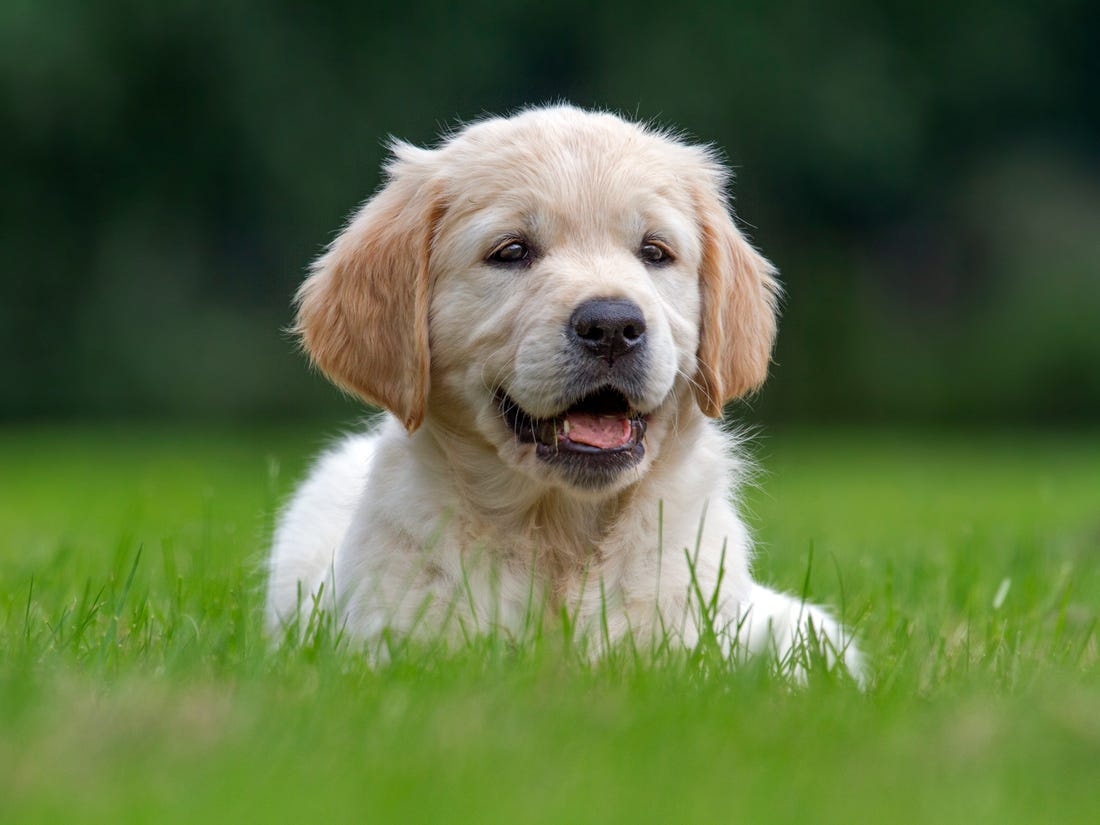

In [86]:
image_mappings['dog1.jpg']

In [87]:
def compare(a, b):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(a)
    plt.subplot(1, 2, 2)
    plt.imshow(b)
    a_v = feat_vec.get_vector(a)
    b_v = feat_vec.get_vector(b)
    print('Similarity: {}'.format(feat_vec.similarity(a_v, b_v)))

Similarity: tensor([0.7975])


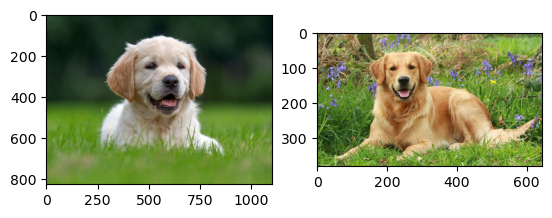

In [88]:
compare(image_mappings['dog1.jpg'], image_mappings['dog2.jpg'])

Similarity: tensor([0.5905])


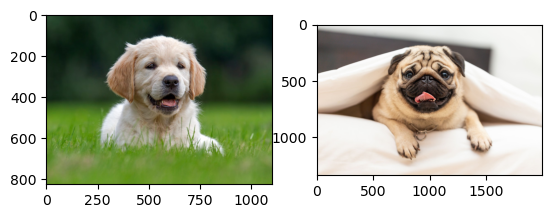

In [89]:
compare(image_mappings['dog1.jpg'], image_mappings['dog3.jpg'])

Similarity: tensor([0.4891])


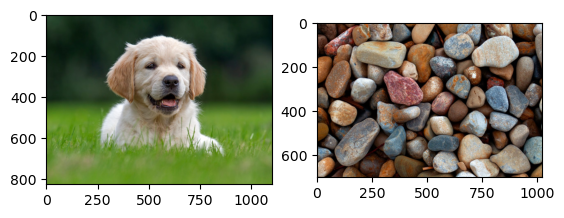

In [90]:
compare(image_mappings['dog1.jpg'], image_mappings['stones.jpg'])

Similarity: tensor([0.4682])


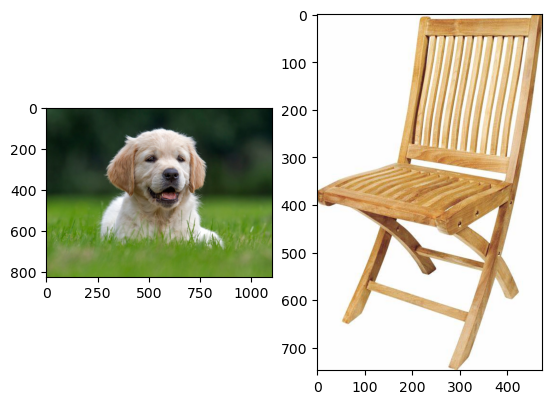

In [91]:
compare(image_mappings['dog1.jpg'], image_mappings['chair.jpg'])

Similarity: tensor([0.5276])


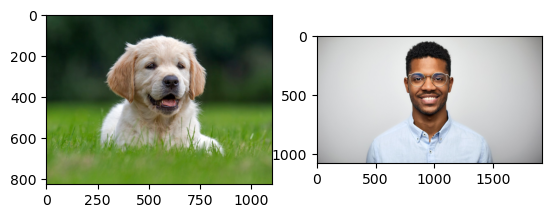

In [92]:
compare(image_mappings['dog1.jpg'], image_mappings['person2.jpg'])

Similarity: tensor([0.7823])


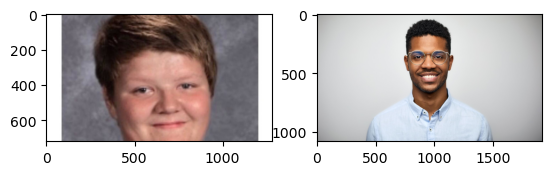

In [93]:
compare(image_mappings['person1.jpg'], image_mappings['person2.jpg'])

In [94]:
import redis

In [95]:
_HOST = "redis"
_PORT = "6379"
r = redis.Redis(
    host=_HOST,
    port=_PORT, 
    # password='password'
)

In [108]:
#  To flush the database before usage, use below command
r.flushdb()

True

We have defined Algorithm as "HNSW" in below cell for usage which is one type of Approximate Nearest neighbours algorithm having much better speed while losing a bit on search quality. HNSW is especially meant for large vector dbs where speed is of utmost concern.  Other option is "FLAT" which can be used when search quality is of high priority and search speed is less important, usually meant for smaller vector dbs.

More details - https://www.pinecone.io/learn/vector-indexes/

In [109]:
from redis.commands.search.field import VectorField, TextField
from redis.commands.search.query import Query
from redis.commands.search.indexDefinition import IndexDefinition, IndexType

index_name = "images"
vector_col_name = "content_vector"

SCHEMA = [
    TextField("content"),
    TextField("metadata"),
    VectorField(vector_col_name, "HNSW", {"TYPE": "FLOAT32", "DIM": 512, "DISTANCE_METRIC": "COSINE"}),
]
# Create the index
try:
    r.ft(index_name).create_index(fields=SCHEMA, definition=IndexDefinition(prefix=[index_name + ":"], index_type=IndexType.HASH))
except Exception as e:
    print("Index already exists")

In [110]:
import pandas as pd
import numpy as np

In [111]:
vector_mappings = {x:feat_vec.get_vector(image_mappings[x]).tolist() for x in image_mappings.keys()}

In [112]:
# initialise data of lists.
data = {'name':image_mappings.keys(), 'images':image_mappings.values()}
 
# Create DataFrame
df = pd.DataFrame(data)
 
df['paths'] = df['name'].map(image_file_name_path_mapping)
df['content'] = df['name']
df[vector_col_name] = vector_mappings.values()

In [113]:
import uuid
import json

def generate_uuid(class_name: str, identifier: str) -> str:
    """ Generate a uuid based on an identifier
    :param identifier: characters used to generate the uuid
    :type identifier: str, required
    :param class_name: classname of the object to create a uuid for
    :type class_name: str, required
    """
    return str(uuid.uuid5(uuid.NAMESPACE_DNS, class_name + identifier))

In [114]:
p = r.pipeline(transaction=False)
for i, row in df.iterrows():
    # convert to numpy array and bytes
    vector = np.array(row['content_vector']).astype(np.float32).tobytes()
    
    # Create a new hash with vector as per the schema defined for index.
    img_db_hash = {
        "content": row['name'],
        "metadata": json.dumps({
                        'name':row['name'],
                        'paths':row['paths']
                    }),
        vector_col_name: vector
    }
    uid = generate_uuid(index_name,  row['name'])
    # create hash
    r.hset(name=f"{index_name}:{uid}", mapping=img_db_hash)
p.execute()

[]

In [115]:
from redis.commands.search.query import Query
import redis

In [116]:
def search_vectors(img, client, top_k=5):
    query_vector = np.array(feat_vec.get_vector(img)).astype(np.float32).tobytes() 
    base_query = f"*=>[KNN {top_k} @{vector_col_name} $vector AS vector_score]"
    query = Query(base_query).return_fields("content", "metadata", "vector_score").sort_by("vector_score").dialect(2)    
 
    try:
        results = client.ft(index_name).search(query, query_params={"vector": query_vector})
    except Exception as e:
        print("Error calling Redis search: ", e)
        return None
 
    return results

# get_similiar_images

In [117]:
ref_img_for_comparison = 'dog1.jpg'
img = image_mappings[ref_img_for_comparison]
res = search_vectors(img, r, top_k=11)

res

Result{11 total, docs: [Document {'id': 'images:bead6fa1-29d6-577f-be99-16b75a73c8a6', 'payload': None, 'vector_score': '0', 'content': 'dog1.jpg', 'metadata': '{"name": "dog1.jpg", "paths": "./images/dog1.jpg"}'}, Document {'id': 'images:e67687e2-8231-5805-9bfb-dc7cbb9f4e79', 'payload': None, 'vector_score': '0.20245808363', 'content': 'dog2.jpg', 'metadata': '{"name": "dog2.jpg", "paths": "./images/dog2.jpg"}'}, Document {'id': 'images:1e3d3b20-3b03-5f18-ad52-9242397767fb', 'payload': None, 'vector_score': '0.209439992905', 'content': 'dog5.jpg', 'metadata': '{"name": "dog5.jpg", "paths": "./images/dog5.jpg"}'}, Document {'id': 'images:0542d405-b10d-593d-b4f0-c482c48b93a1', 'payload': None, 'vector_score': '0.334551155567', 'content': 'dog4.jpg', 'metadata': '{"name": "dog4.jpg", "paths": "./images/dog4.jpg"}'}, Document {'id': 'images:9b9c905e-766e-5e42-975a-566fea3b98d8', 'payload': None, 'vector_score': '0.409486532211', 'content': 'dog3.jpg', 'metadata': '{"name": "dog3.jpg", "pa

Nearest neighbours and similarity in decreasing order
Similarity : 1.0
Similarity : 0.7975419163699999
Similarity : 0.790560007095
Similarity : 0.665448844433
Similarity : 0.590513467789
Similarity : 0.539174675941
Similarity : 0.5348777771
Similarity : 0.527593553066
Similarity : 0.524067521095
Similarity : 0.48912107944500005


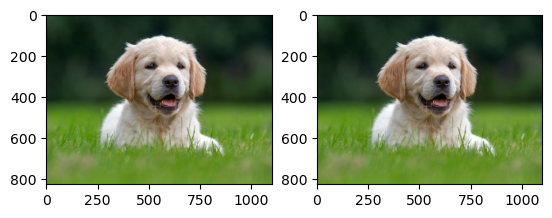

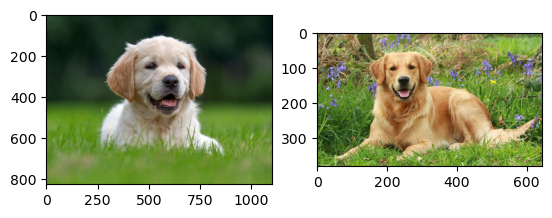

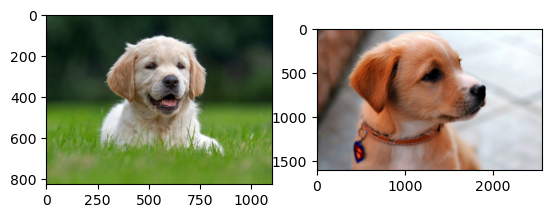

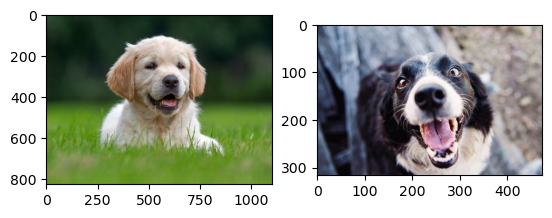

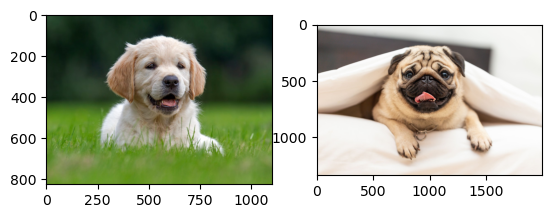

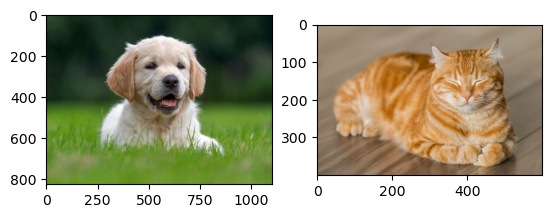

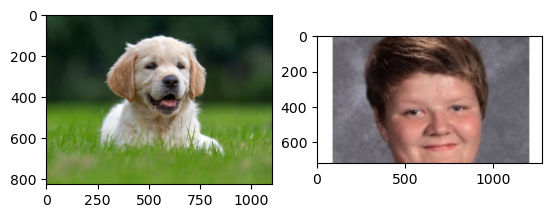

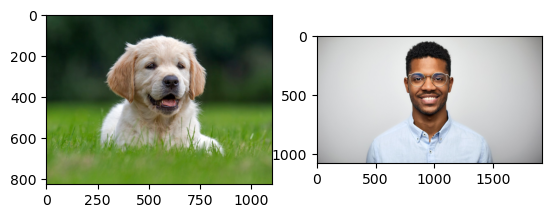

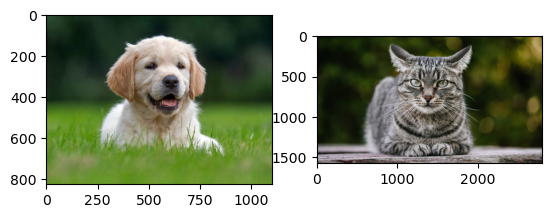

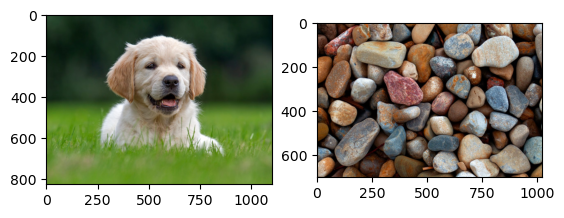

In [118]:
print("Nearest neighbours and similarity in decreasing order")

for neighbour_ind in range(len(res.docs)):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_mappings[ref_img_for_comparison])
    plt.subplot(1, 2, 2)
    plt.imshow(image_mappings[res.docs[neighbour_ind].content])
    print('Similarity : {}'.format(1- float(res.docs[neighbour_ind].vector_score)))

Now , lets check the same for an unknown image which we didnt yet read so far and try to find its similarity

Top 5 neighbours and similarity in decreasing order
Similarity : 0.633963644505
Similarity : 0.552709341049
Similarity : 0.515622317791
Similarity : 0.49434751272199995
Similarity : 0.48603546619399995


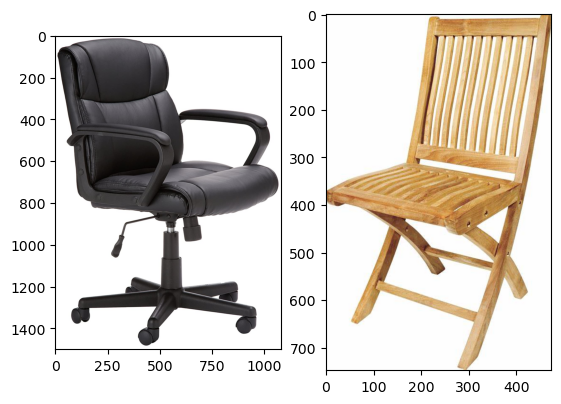

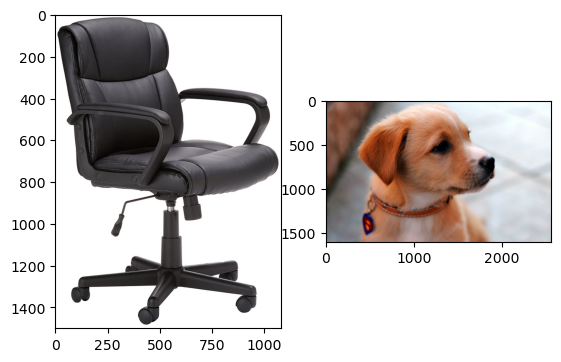

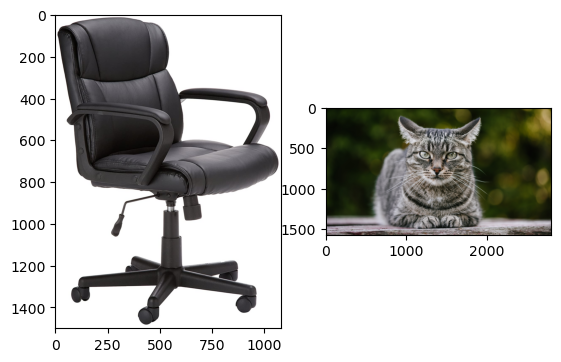

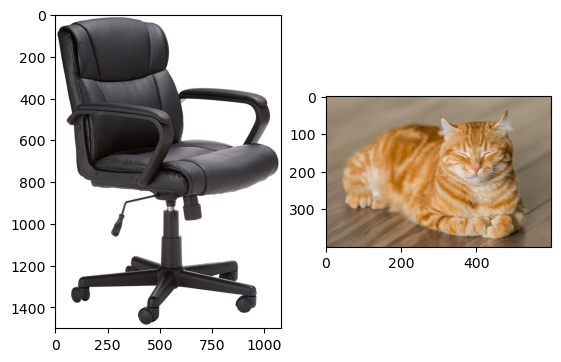

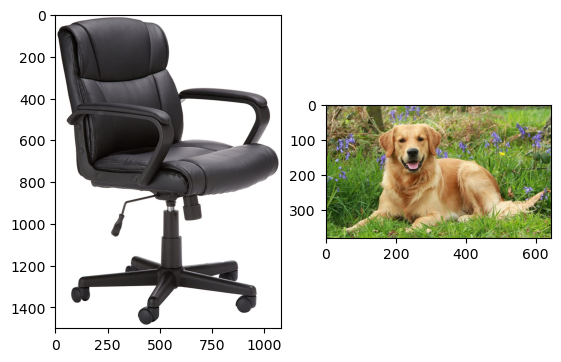

In [119]:
unk_img_paths= ["./test_img/unk1.jpg", "./test_img/unk2.jpg"]
unk_img_maps = {x.split("/")[-1]:Image.open(x) for x in unk_img_paths}
unk_img = unk_img_maps['unk2.jpg']
result_imgs = search_vectors(unk_img, r, top_k=5)
print("Top 5 neighbours and similarity in decreasing order")

for neighbour_ind in range(len(result_imgs.docs)):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(unk_img)
    plt.subplot(1, 2, 2)
    plt.imshow(image_mappings[result_imgs.docs[neighbour_ind].content])
    print('Similarity : {}'.format(1- float(result_imgs.docs[neighbour_ind].vector_score)))

We can see the vector similarity works here and is able to return the most similiar pic of chair in top result

References:

1) https://blog.baeke.info/2023/03/21/storing-and-querying-for-embeddings-with-redis/